You might need to install this on your system:

apt-get install python3-opencv git

In [ ]:
import os
orig_data_dir = os.getcwd()+'/images'
train_dir = os.getcwd()+"/TRAIN"
test_dir = os.getcwd()+"/TEST"
txt_file_train = os.getcwd()+'/annotations/trainval.txt'
txt_file_test = os.getcwd()+'/annotations/test.txt'

In [ ]:
if not os.path.isdir(train_dir):
  !wget https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz

In [ ]:
if not os.path.isdir(train_dir):
  !tar -xvf images.tar.gz

In [ ]:
if not os.path.isdir(train_dir):
  !wget https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz

In [ ]:
if not os.path.isdir(train_dir):
  !tar -xvf annotations.tar.gz

In [ ]:
#"""
# !rm k -r
if not os.path.isdir('k'):
 !git clone -b development14 https://github.com/joaopauloschuler/k-neural-api.git k
else:
 !cd k && git pull
#"""
!cd k && pip install .

Already up to date.
Processing /content/k
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for cai: filename=cai-0.1.5-py3-none-any.whl size=57350 sha256=a424deddfbd120df08bc180c9622cc06977a1cc69ae04022e7d8ec041e86ada0
  Stored in directory: /tmp/pip-ephem-wheel-cache-3bhxcu8t/wheels/c1/8a/57/56dbba25eff58e52e5365435c4fa102ad8d6f9787d3b4db13a
Successfully built cai
  Attempting uninstall: cai
    Found existing installation: cai 0.1.5
    Uninstalling cai-0.1.5:
      Successfully uninstalled cai-0.1.5


In [ ]:
import cai.layers
import cai.datasets
import cai.models
import cai.efficientnet
import numpy as np
from tensorflow import keras
from tensorflow.keras import backend
from tensorflow.keras import layers
import gc
import multiprocessing
import random
import tensorflow as tf
print("Tensorflow version:", tf.version.VERSION)
print("Keras version:", keras.__version__)
print("CPU cores:", multiprocessing.cpu_count())
import psutil
print('RAM:', (psutil.virtual_memory().total / 1e9),'GB')
print(tf.config.list_physical_devices('GPU'))
import matplotlib.pylab as plt
import cv2
from sklearn.metrics import classification_report
import shutil

Tensorflow version: 2.7.0
Keras version: 2.7.0
CPU cores: 8
RAM: 54.76702208 GB
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

In [ ]:
def CopyImagesToFolders(orig_data_dir, dest_data_dir, txt_file, verbose=True, prefix='class_'):
  # Load the CSV file.
  # Image CLASS-ID SPECIES BREED ID
  if verbose: print('Loading', txt_file)
  with open (txt_file, "r") as myfile:
    csv_lines=myfile.readlines()

  # Transform the CSV file into an array  
  line_count = 0
  a_lines = []
  for str_line in csv_lines:
    if line_count > 0: 
      a_line = str_line.replace('\n', '').split(' ')
      a_lines.append(a_line)
    line_count = line_count + 1
  
  # create destination folder
  if not os.path.isdir(dest_data_dir):
    os.mkdir(dest_data_dir)

  # Save cropped images
  line_count = 0
  failed_count = 0
  original_count = 0
  last_image_file = ''
  for a_line in a_lines:
    dest_folder_name = dest_data_dir+'/'+prefix+a_line[1]
    dest_file_name = dest_folder_name+'/'+a_line[0]
    orig_file_name = orig_data_dir+'/'+ a_line[0]
    found = False
    if os.path.isfile(orig_file_name+'.jpg'):
      dest_file_name = dest_folder_name+'/'+a_line[0]+'.jpg'
      orig_file_name = orig_data_dir+'/'+ a_line[0]+'.jpg'
      found = True
    if os.path.isfile(orig_file_name+'.png'):
      dest_file_name = dest_folder_name+'/'+a_line[0]+'.png'
      orig_file_name = orig_data_dir+'/'+ a_line[0]+'.png'
      found = True
    if verbose: print(line_count,':', a_line, dest_file_name)
    if (found):
      if not os.path.isdir(dest_folder_name):
        os.mkdir(dest_folder_name)
      if verbose: print('Copying file from', orig_file_name,'to',dest_file_name)
      shutil.copyfile(orig_file_name, dest_file_name)
    else:
      if verbose: print('File does not exist:', orig_file_name)
      failed_count = failed_count + 1
    line_count = line_count + 1
  print("Processed files:", line_count, "Failed count: ", failed_count, "Original count:", original_count)

In [ ]:
if not os.path.isdir(train_dir):
  CopyImagesToFolders(orig_data_dir=orig_data_dir, dest_data_dir=train_dir, txt_file=txt_file_train, verbose=True, prefix='class_')

In [ ]:
if not os.path.isdir(test_dir):
  CopyImagesToFolders(orig_data_dir=orig_data_dir, dest_data_dir=test_dir, txt_file=txt_file_test, verbose=True, prefix='class_')

In [ ]:
num_classes = 37
batch_size = 32
epochs = 150
target_size_x = 224 # default value is 224
target_size_y = 224 # default value is 224

In [ ]:
print(os.listdir(train_dir))
print(os.listdir(test_dir))

['class_27', 'class_10', 'class_15', 'class_25', 'class_9', 'class_8', 'class_30', 'class_24', 'class_4', 'class_1', 'class_32', 'class_2', 'class_22', 'class_7', 'class_35', 'class_36', 'class_5', 'class_21', 'class_12', 'class_29', 'class_31', 'class_13', 'class_18', 'class_37', 'class_28', 'class_11', 'class_34', 'class_3', 'class_14', 'class_19', 'class_23', 'class_26', 'class_6', 'class_17', 'class_20', 'class_16', 'class_33']
['class_27', 'class_10', 'class_15', 'class_25', 'class_9', 'class_8', 'class_30', 'class_24', 'class_4', 'class_1', 'class_32', 'class_2', 'class_22', 'class_7', 'class_35', 'class_36', 'class_5', 'class_21', 'class_12', 'class_29', 'class_31', 'class_13', 'class_18', 'class_37', 'class_28', 'class_11', 'class_34', 'class_3', 'class_14', 'class_19', 'class_23', 'class_26', 'class_6', 'class_17', 'class_20', 'class_16', 'class_33']


In [ ]:
from tensorflow.python.profiler.model_analyzer import profile
from tensorflow.python.profiler.option_builder import ProfileOptionBuilder

def get_flops(model):
  forward_pass = tf.function(
      model.call,
      input_signature=[tf.TensorSpec(shape=(1,) + model.input_shape[1:])])

  graph_info = profile(forward_pass.get_concrete_function().graph,
                          options=ProfileOptionBuilder.float_operation())

  # The //2 is necessary since `profile` counts multiply and accumulate
  # as two flops, here we report the total number of multiply accumulate ops
  flops = graph_info.total_float_ops // 2
  return flops

In [ ]:
datagen = cai.util.create_image_generator(rotation_range=20, width_shift_range=0.3, height_shift_range=0.3, 
  channel_shift_range=0.0) 

def cyclical_adv_lrscheduler25(epoch):
    """CAI Cyclical and Advanced Learning Rate Scheduler.
    # Arguments
        epoch: integer with current epoch count.
    # Returns
        float with desired learning rate.
    """
    base_learning = 0.001
    local_epoch = epoch % 25
    if local_epoch < 7:
       return base_learning * (1 + 0.5*local_epoch)
    else:
       return (base_learning * 4) * ( 0.85**(local_epoch-7) )

# Load the dataset

In [ ]:
train_x, val_x, aux_test_x, train_y, val_y, aux_test_y, classweight, classes = cai.datasets.load_images_from_folders(seed=7,
  root_dir=train_dir, lab=False, 
  verbose=True, bipolar=False, base_model_name='oxford_pets',
  has_training=True, has_validation=True, has_testing=False,
  training_size=0.9, validation_size=0.1, test_size=0.0,
  smart_resize=True,
  target_size=(target_size_x, target_size_y))

aux_train_x, aux_val_x, test_x, aux_train_y, aux_val_y, test_y, classweight, classes = cai.datasets.load_images_from_folders(seed=7,
  root_dir=test_dir, lab=False, 
  verbose=True, bipolar=False, base_model_name='oxford_pets',
  has_training=False, has_validation=False, has_testing=True,
  smart_resize=True,
  training_size=0.0, validation_size=0.0, test_size=1,
  target_size=(target_size_x, target_size_y))

print(train_x.shape,val_x.shape,test_x.shape)
print(train_y.shape,val_y.shape,test_y.shape)

Loading  37  classes.
smart resize is enabled.
loading train images
train shape is: (3309, 224, 224, 3)
loading validation images
validation shape is: (370, 224, 224, 3)
Channel  0  min: 0.0  max: 1.0
Channel  1  min: 0.0  max: 1.0
Channel  2  min: 0.0  max: 1.0
Loaded.
Loading  37  classes.
smart resize is enabled.
loading test images
test shape is: (3668, 224, 224, 3)
Loaded.
(3309, 224, 224, 3) (370, 224, 224, 3) (3668, 224, 224, 3)
(3309, 37) (370, 37) (3668, 37)


In [ ]:
def work_on_efficientnet(show_model=False, run_fit=False, test_results=False, calc_f1=False):
  monitor='val_accuracy'
  if (calc_f1): 
    test_results=True
  if (show_model):
    input_shape = (target_size_x, target_size_y, 3)
  else:
    input_shape = (None, None, 3)
  for kType in [cai.layers.D6_32ch()]:
      basefilename = 'JP30D11-EfficientNet-OxfordIIIPetDataset-'+str(kType)
      best_result_file_name = basefilename+'-best_result.hdf5'
      print('Running: '+basefilename)
      if kType == -1:
        model = cai.efficientnet.EfficientNetB0(
          include_top=True,
          input_shape=input_shape,
          classes=num_classes)
      else:
        model = cai.efficientnet.kEfficientNetB0(
          include_top=True,
          input_shape=input_shape,
          classes=num_classes,
          kType=kType)
      
      optimizer = keras.optimizers.RMSprop()
      optimizer = mixed_precision.LossScaleOptimizer(optimizer)
      model.compile(
        loss='categorical_crossentropy',
        optimizer=optimizer,
        metrics=['accuracy'])

      if (show_model): 
        model.summary()
        print('model flops:',get_flops(model))

      save_best = keras.callbacks.ModelCheckpoint(
            filepath=best_result_file_name,
            monitor=monitor,
            verbose=1,
            save_best_only=True,
            save_weights_only=False,
            mode='max',
            save_freq='epoch')

      if (run_fit):
        history = model.fit(
          x = datagen.flow(train_x, train_y, batch_size=batch_size),
          epochs=epochs,
          batch_size=batch_size,
          validation_data=(val_x, val_y),
          callbacks=[save_best, tf.keras.callbacks.LearningRateScheduler(cyclical_adv_lrscheduler25)],
          workers=max([multiprocessing.cpu_count(), 4]) 
        )
        plt.figure()
        plt.ylabel("Accuracy (training and validation)")
        plt.xlabel("Epochs")
        plt.ylim([0,1])
        plt.plot(history.history["accuracy"])
        plt.plot(history.history["val_accuracy"])
      if (test_results):
        print('Best Model Results: '+basefilename)
        model = cai.models.load_kereas_model(best_result_file_name)
        evaluated = model.evaluate(test_x,test_y)
        for metric, name in zip(evaluated,["loss","acc"]):
              print(name,metric)
      if (calc_f1):
        pred_y = model.predict(test_x)
        print("Predicted Shape:", pred_y.shape)
        pred_classes_y = np.array(list(np.argmax(pred_y, axis=1)))
        test_classes_y = np.array(list(np.argmax(test_y, axis=1)))
        print("Pred classes shape:",pred_classes_y.shape)
        print("Test classes shape:",test_classes_y.shape)
        report = classification_report(test_classes_y, pred_classes_y, digits=4)
        print(report)
      print('Finished: '+basefilename)

# Show Models

In [ ]:
work_on_efficientnet(show_model=True, run_fit=False, test_results=False)

Running: JP30D11-EfficientNet-OxfordIIIPetDataset-13
Model: "kEffNet-b0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 k_stem_conv_pad (ZeroPadding2D  (None, 225, 225, 3)  0          ['input_1[0][0]']                
 )                                                                                                
                                                                                                  
 k_stem_conv (Conv2D)           (None, 112, 112, 32  864         ['k_stem_conv_pad[0][0]']        
                                )   

# Fitting

Running: JP30D11-EfficientNet-OxfordIIIPetDataset-13
Epoch 1/150
104/104 [==============================] - ETA: 0s - loss: 4.1036 - accuracy: 0.0305
Epoch 00001: val_accuracy improved from -inf to 0.02703, saving model to JP30D11-EfficientNet-OxfordIIIPetDataset-13-best_result.hdf5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


104/104 [==============================] - 126s 548ms/step - loss: 4.1036 - accuracy: 0.0305 - val_loss: 3.6123 - val_accuracy: 0.0270 - lr: 0.0010
Epoch 2/150
104/104 [==============================] - ETA: 0s - loss: 3.9459 - accuracy: 0.0272
Epoch 00002: val_accuracy did not improve from 0.02703
104/104 [==============================] - 43s 410ms/step - loss: 3.9459 - accuracy: 0.0272 - val_loss: 3.6188 - val_accuracy: 0.0270 - lr: 0.0015
Epoch 3/150
104/104 [==============================] - ETA: 0s - loss: 3.8417 - accuracy: 0.0332
Epoch 00003: val_accuracy did not improve from 0.02703
104/104 [==============================] - 44s 413ms/step - loss: 3.8417 - accuracy: 0.0332 - val_loss: 3.6477 - val_accuracy: 0.0270 - lr: 0.0020
Epoch 4/150
104/104 [==============================] - ETA: 0s - loss: 3.7225 - accuracy: 0.0332
Epoch 00004: val_accuracy improved from 0.02703 to 0.04324, saving model to JP30D11-EfficientNet-OxfordIIIPetDataset-13-best_result.hdf5
104/104 [===========

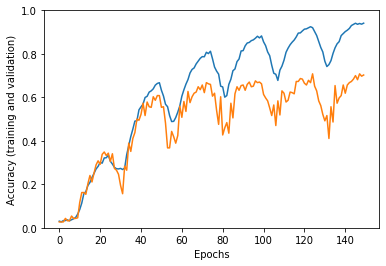

In [ ]:
work_on_efficientnet(show_model=False, run_fit=True, test_results=True)

# Test Results

In [ ]:
work_on_efficientnet(show_model=False, run_fit=False, test_results=True)

Running: JP30D11-EfficientNet-OxfordIIIPetDataset-13
Best Model Results: JP30D11-EfficientNet-OxfordIIIPetDataset-13
115/115 [==============================] - 20s 62ms/step - loss: 1.7688 - accuracy: 0.6292
loss 1.7688311338424683
acc 0.6292257308959961
Finished: JP30D11-EfficientNet-OxfordIIIPetDataset-13


# Calculate F1

In [ ]:
work_on_efficientnet(show_model=False, run_fit=False, test_results=True, calc_f1=True)

Running: JP30D11-EfficientNet-OxfordIIIPetDataset-13
Best Model Results: JP30D11-EfficientNet-OxfordIIIPetDataset-13
115/115 [==============================] - 21s 63ms/step - loss: 1.7688 - accuracy: 0.6292
loss 1.7688311338424683
acc 0.6292257308959961
Predicted Shape: (3668, 37)
Pred classes shape: (3668,)
Test classes shape: (3668,)
              precision    recall  f1-score   support

           0     0.5776    0.6907    0.6291        97
           1     0.5593    0.6600    0.6055       100
           2     0.6087    0.2800    0.3836       100
           3     0.7312    0.7010    0.7158        97
           4     0.4624    0.4300    0.4456       100
           5     0.6415    0.3400    0.4444       100
           6     0.3969    0.7700    0.5238       100
           7     0.6373    0.6500    0.6436       100
           8     0.5798    0.6900    0.6301       100
           9     0.7647    0.7800    0.7723       100
          10     0.7624    0.7778    0.7700        99
          11